In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements
from skimage.morphology import label

from z3 import *
from IPython.display import Markdown, display

In [2]:
# Going back to look at an old puzzle to try to get started on the Dec 2020
# Use backtracking to solve


url='https://www.janestreet.com/puzzles/twenty-four-seven/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')

y =[text for text in soup.body.stripped_strings]
#display([[i,j] for i,j in enumerate(y)])
display(Markdown("**"+y[6]+"**\n\n"+str(" ".join(y[7:12]))))

**Twenty Four Seven**

The grid is incomplete. Place numbers in some of the empty cells below so that in total the grid contains one 1, two 2’s, etc., up to seven 7’s. Furthermore, each row and column must contain exactly 4 numbers which sum to 20. Finally, the numbered cells must form a connected region*, but every 2-by-2 subsquare in the completed grid must contain at least one empty cell. The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid. (*Updated 2018-06-14 to clarify that cells connect along edges only .)

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/06/20180604_20_4_7.png" width="250" height="300">

In [3]:
grid =np.array([[0,4,0,0,0,0,0],
                [0,0,6,3,0,0,6],
                [0,0,0,0,0,5,5],
                [0,0,0,4,0,0,0],
                [4,7,0,0,0,0,0],
                [2,0,0,7,4,0,0],
                [0,0,0,0,0,1,0]])


grid[grid==0] =-1

In [4]:
def neighbours( i, j):
        l=[]
        if i-1 >= 0:
            l.append((i-1,j))
        if i+1 < 7:
            l.append((i+1,j))
        if j-1 >= 0:
            l.append((i,j-1))
        if j+1 < 7:
            l.append((i,j+1))
        return l

def areas(grid):
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))
    return np.prod(areas)

9 solutions took 0.2024 seconds



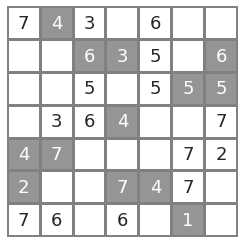


 Score is 240


In [15]:
    
    
start = time.time()
s = Solver()

X = [[Int("X_%s%s" % (i+1,j+1)) for j in range(7) ] for i in range(7) ]

# limit the values and place the fixed values
s += [And(X[i][j]>=0,X[i][j] <=7) for j in range(7) for i in range(7) ]
s += [X[i][j] == int(grid[i,j]) for j in range(7) for i in range(7) if grid[i,j] > 0]

# Row/Col Sums
s += [Sum([X[i][j] for i in range(7)]) == 20 for j in range(7)]
s += [Sum([X[i][j] for j in range(7)]) == 20 for i in range(7)]

s += [PbEq([(X[i][j] ==0,1) for i in range(7)],3) for j in range(7)]
s += [PbEq([(X[i][j] ==0,1) for j in range(7)],3) for i in range(7)]
  
# only n instances of n  
for n in range(1,8):
      s += PbEq([(X[i][j] == n,1) for j in range(7) for i in range(7)],n)

#  row and col sums      
s += [Sum([X[i][j] for j in range(7)]) == 20 for i in range(7)]
s += [Sum([X[i][j] for i in range(7)]) == 20 for j in range(7)] 

# no 2x2
s += [Or(X[i][j] ==0,X[i+1][j] ==0,X[i][j+1] ==0,X[i+1][j+1] ==0) for j in range(6) for i in range(6)]

s += [Implies(X[i][j] !=0,Or([X[k][l] !=0 for (k,l) in neighbours(i,j)])) for j in range(7) for i in range(7) ] 
    

# coding up the connectivity is hard so just solve and test then exclude solutions that are not connected
count = 0
while True:   
    if s.check() == sat:
        count += 1
        m = s.model()
        x = np.array([[m.evaluate(X[i][j]).as_long() for j in range(7)] for i in range(7)])
        if np.max(label(x != 0,connectivity=1)) == 1 :
            break
        s += Or([X[i][j]!=int(x[i,j]) for j in range(6) for i in range(6)])
    else:
        print("failed to solve") 
        break
    
print('{} solutions took {:0.4f} seconds\n'.format(count,time.time()-start))
    
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5)) 
y = np.array(x).astype('int').astype('str')
y[y=="0"] =""
ax =sns.heatmap(x==grid,annot=y,cbar=False,cmap="Greys",fmt="",linewidths=2,center= 1,linecolor="grey",annot_kws={"size":18})
ax.axis("off")
plt.tight_layout()
plt.show()
print('\n Score is {:,.0f}'.format((areas(x))))


In [13]:
url='https://www.janestreet.com/puzzles/solutions/june-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]

display(Markdown("### "+y[6]+"\n\n"+str("\n".join(y[7:11]))))

### June 2018 solution

The completed grid is shown to the left. The product of the areas of the regions of blank squares is
240
.
Congrats to everyone who solved this month’s puzzle!

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/07/20180702_20_4_7_ans.png" width="250" height="300">